<a href="https://colab.research.google.com/github/hyemworks/make-your-firstGAN-with-pytorch/blob/main/ch03_performance_improvement_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b>Chapter 03 &nbsp;&nbsp;&nbsp;&nbsp; Performance Improvement Techniques

In [1]:
# mount Drive to access data files

from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [4]:
# import pandas to read *.csv files

import pandas

df = pandas.read_csv("mount/My Drive/Colab Notebooks/make-your-firstGAN-with-pytorch/mnist_data/mnist_train.csv", header = None)

In [5]:
# import matplotlib to show img

import matplotlib.pyplot as plt

In [7]:
# import torch

import torch
import torch.nn as nn

In [35]:
class Classifier(nn.Module): # inheritance


    # Constructor
    def __init__(self):

        # 부모 클래스 초기화
        super().__init__()

        # 신경망 레이어 정의 - 통과시킬 레이어를 순서대로 기술
        self.model = nn.Sequential(
            nn.Linear(784, 200),    # Linear : 완전연결 매핑을 의미 => 여기에서는 훈련 시 노드를 업데이트할 가중치에 대한 정보도 포함되어 있음
            # nn.Sigmoid(),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 10),     # Linear : ,,
            nn.Sigmoid()
            # nn.LeakyReLU(0.02)
        )

        # Loss Function 설정
        # self.loss_function = nn.MSELoss()
        self.loss_function = nn.BCELoss()

        # Optimizer 설정
        # self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        self.optimizer = torch.optim.Adam(self.parameters())

        # 훈련 시각화 (train 함수에서 사용될 변수 초기화)
        self.counter = 0
        self.progress = []



    # forward function : 네트워크에 정보 전달
    def forward(self, inputs):
        # 모델 실행
        return self.model(inputs)


      
    # train
    def train(self, inputs, targets):
        # inputs  : 신경망에 전달할 입력  
        # targets : 원하는 목표 --> 이를 통해 손실을 계산

        ### 신경망 출력 계산
        outputs = self.forward(inputs)  # train 함수에서 가장 먼저 해야할 일! == forward()로 입력값을 신경망에 전달하여 결과를 얻어내는 것
        
        ### 손실 계산
        loss = self.loss_function(outputs, targets)
        #  계산 그래프의 마지막 노드는 손실함수!
        #   => 손실 계산을 위해 각 노드에서 기울기가 변하는 것은 각 학습 파라미터가 변할 때마다 손실이 변하는 것과 같음
        

        ### 훈련 시각화 (모니터링)
        # 카운터를 증가시키고 10회마다 오차 저장
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item()) # item() : 텐서에서 값을 꺼내오는 함수
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)


        ### 손실을 사용해 네트워크의 가중치를 업데이트
        # 기울기 초기화
        self.optimizer.zero_grad()  # 계산 그래프의 기울기가 모두 0으로 초기화
                                    #   : 신경망을 훈련할 때마다 매번 기울기는 0으로 설정되어 있어야 함
                                    #      => 그렇게 하지 않으면 loss.backward()를 따라 계산마다 쌓이게 됨
        # 역전파 실행
        loss.backward()
        # 가중치 갱신
        self.optimizer.step()


  
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    

In [10]:
from torch.utils.data import Dataset

In [12]:
# MNIST DATASET CLASS

class MnistDataset(Dataset):

  # Constructor
  def __init__(self, csv_file):
    # csv_file 읽어오기
    self.data_df = pandas.read_csv(csv_file, header=None)


  def __len__(self):
    # 데이터 프레임의 길이 반환
    return len(self.data_df)


  # 특정 아이템을 인덱스를 통해 접근가능한 함수
  def __getitem__(self,index):
    # 이미지 (목표)레이블
    label = self.data_df.iloc[index,0]  # 각 행의 첫번째 인덱스, 즉 정답레이블을 읽어옴.(정답은 0~9까지 존재)
    target = torch.zeros((10))          # target이란 "정답" 종이 만들기
    target[label] = 1.0                 # 정답 레이블의 위치에만 1로 지정. 나머지는 0 (원-핫 인코딩 방식)

    # 0 - 255의 이미지를 0 - 1로 정규화
    image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values)/255.0

    # 레이블, 이미지 데이터 텐서, 목표 텐서 반환
    return label, image_values, target



  # MNIST 데이터셋 내의 특정 이미지를 골라 차트를 그려보는 메서드
  def plot_image(self, index):
    img = self.data_df.iloc[index,1:].values.reshape(28,28) # 2D로 변형
    plt.title("label = " + str(self.data_df.iloc[index,0])) # 정답레이블 제목으로 붙이기
    plt.imshow(img, interpolation='none', cmap = 'Blues')   # 나타내기


---
---

<br>

## 손실함수

<br>

> ✅ **회귀$^{regression}$**<br>
: 연속적인 숫자에 대해 결과를 출력하도록 구성되어 있는 문제<br>
<br>
  &nbsp;&nbsp;▶ **평균제곱오차법$^{mean-squared-error}$, MSELoss()** <br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*ex) 섭씨온도와 같은 숫자를 맞춰야하는 모델 만드는 경우*<br>

<br>

> ✅ **분류$^{classification}$**<br>
: 참/거짓이나 1/0 같은 이산형 결과를 내도록 만들어야 하는 문제<br>
 <br>
  &nbsp;&nbsp;▶ **이진교차 엔트로피$^{binary-cross-entropy}$ ; BCELoss()**<br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*ex) 이미지가 고양이인가 아닌가를 판단하는 모델을 만드는 경우*
 


<br>

✅ **nn.BCELoss()**

  : 파이토치에서 이진교차 엔트로피에 대한 함수를 제공해주는 형태.<br>

```
# 신경망 구조 정의
self.loss_function = nn.BCELoss()
```


➡ 상단 분류기 클래스에서 손실함수만 MSELoss()에서 BCELoss()로 변경해주자!

In [14]:
# Load MNIST Train Data

mnist_dataset = MnistDataset("mount/My Drive/Colab Notebooks/make-your-firstGAN-with-pytorch/mnist_data/mnist_train.csv")

In [15]:
%%time

# 신경망 생성
C = Classifier()


# MNIST 데이터에 대해 훈련 진행
epochs = 3

for i in range(epochs):
  print('training epoch', i+1, 'of', epochs)
  for label, image_data_tensor, target_tensor in mnist_dataset:
    C.train(image_data_tensor, target_tensor)

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 3min 33s, sys: 2.12 s, total: 3min 35s
Wall time: 3min 35s


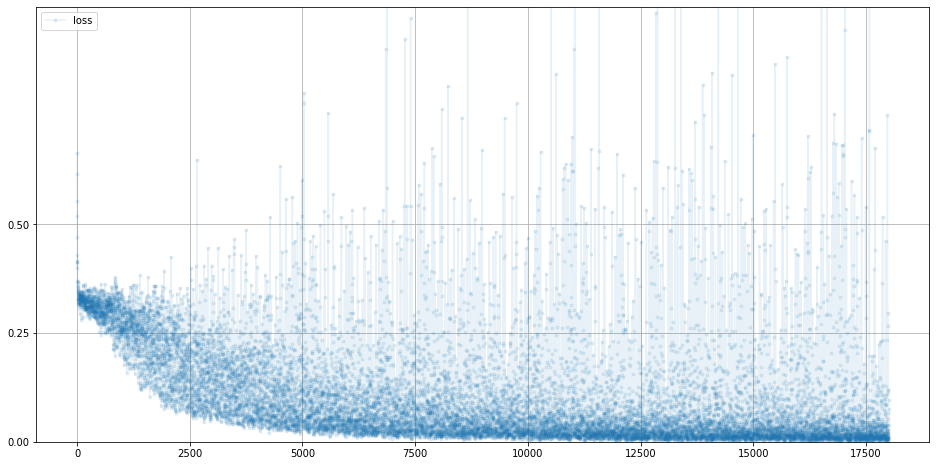

In [16]:
# plot classifer error

C.plot_progress()

In [17]:
# Load MNIST Test Data

mnist_test_dataset = MnistDataset("mount/My Drive/Colab Notebooks/make-your-firstGAN-with-pytorch/mnist_data/mnist_test.csv")

'\n출력 output을 단순한 넘파이 배열로 변환한 후\n다시 데이터프레임으로 래핑해서\n막대도표로 표현함!\n'

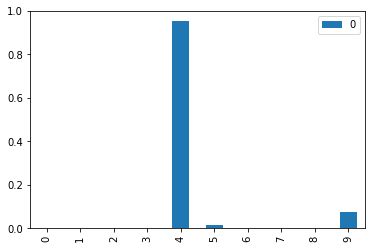

In [18]:
# Visualize the answer given by the neural network

record = 19
image_data = mnist_test_dataset[record][1]

# query form trained network
output = C.forward(image_data)

# plot output tensor
pandas.DataFrame(output.detach().numpy()).plot(kind='bar', legend='False', ylim=(0,1))
'''
출력 output을 단순한 넘파이 배열로 변환한 후
다시 데이터프레임으로 래핑해서
막대도표로 표현함!
'''

<br>

## 활성화함수

<br>


✅ **시그모이드 함수**<br>
  : S 모양의 로지스틱함수는 신경망 초기에 많이 사용됨.<br>
  : 동물의 뉴런에 일어나는 신호 전달현상과 비슷하고, 기울기를 계산하기가 수학적으로 상당히 간편
<br>
  ▶ 단점<br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: **포화$^{saturation}$**<br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: 신경망 훈련시 가중치를 업데이트 하기위해 그래디언트를 구하는 과정이 있는데,<br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;이때 기울기가 소실(gradient vanishing)될 수 있음!

  <br>


✅ **정류선형 유닛$^{rectified-linear-unit}$ (ReLU)**<br>
  : S 모양의 로지스틱함수를 대체하는 함수
<br>
  ▶ 단점<br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: 0보다 작은 값들에 대해서는 경사가 0이기 때문에 이에 따라 기울기가 소실되는 문제가 여전히 발생!<br>

  <br>

✅ **리키 ReLU$^{leaky-ReLU}$**<br>
  * ReLU 함수를 보완한 손실함수<br>
  * 0보다 작은 경우에는, **미세한 기울기**를 허용<br>

```
# How to use leaky ReLU function in Neural Network Layer

self.model = nn.Sequential(
  nn.Linear(784,200)
  nn.LeakyReLU(0.02)
  nn.Linear(200,10)
  nn.LeakyReLU(0.02)
)

```

&nbsp;&nbsp;↪ 여기서, 0.02는 함수의 왼쪽 부분에 대한 기울기를 의미


<br>

➡ 상단 분류기 클래스에서 활성화 함수만 MSELoss()에서 BCELoss()로 변경해주자!

In [20]:
%%time

# 신경망 생성
C = Classifier()


# MNIST 데이터에 대해 훈련 진행
epochs = 3

for i in range(epochs):
  print('training epoch', i+1, 'of', epochs)
  for label, image_data_tensor, target_tensor in mnist_dataset:
    C.train(image_data_tensor, target_tensor)

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 3min 44s, sys: 2.43 s, total: 3min 46s
Wall time: 3min 46s


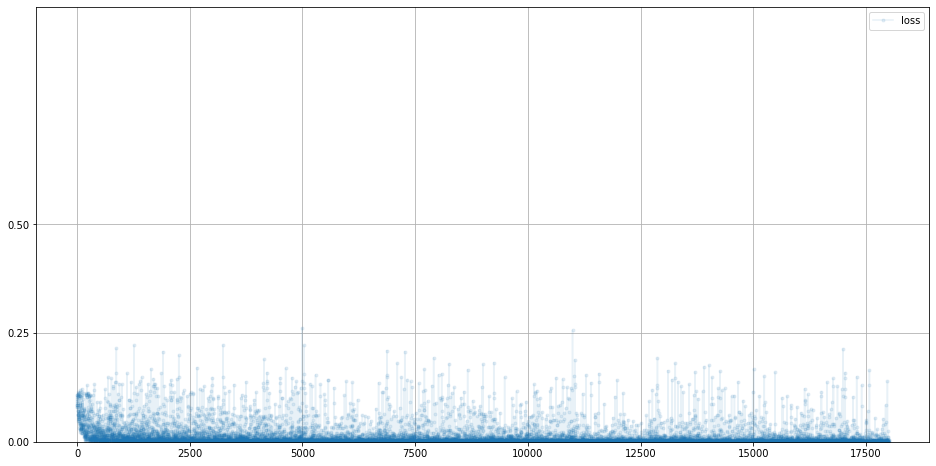

In [21]:
# plot classifer error

C.plot_progress()

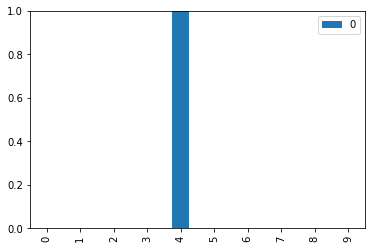

In [22]:
# Visualize the answer given by the neural network

record = 19
image_data = mnist_test_dataset[record][1]

# query form trained network
output = C.forward(image_data)

# plot output tensor
pandas.DataFrame(output.detach().numpy()).plot(kind='bar', legend='False', ylim=(0,1))

<br>

## 옵티마이저

✅ **SGD$^{Stochastic-Gradient-Descent}$, 확률적 경사하강법**<br>
  ▶ 단점<br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: 국소 최적해에 빠질 수 있음.<br>
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: 모든 학습 파라미터에 단일한 학습률을 적용함.<br>

  <br>

✅ **Adam$^{Adaptive-Moment-Estimation}$**<br>
  : 관성을 이용해 국소 최적해로 빠져버릴 가능성을 줄이는 옵티마이저.<br>
  : 학습 파라미터에 대해 **각각 다른 학습률**을 적용<br>
  : 학습을 할 때 이 파라미터들을 계속 **상황에 따라 수정**함.

<br>

> 🦋 그외 참고자료<br>
: https://onevision.tistory.com/entry/Optimizer-의-종류와-특성-Momentum-RMSProp-Adam<br>
: https://morioh.com/p/3f20600908f3
<br>
<br>
🦋 **EMA$^{Exponential-Moving-Average}$**, 지수이동평균<br>
: 가중변수 $α$를 이용하여 최근 수치의 영향력은 높이고 과거 수치의 영향력은 낮추는 것
$${ x_k = {\alpha}p_k + (1-{\alpha})x_{k-1} {\quad} where {\quad} {α}= {2 \over {N+2}}}$$

<br>

```
# Set Optimizer
self.optimizer = torch.optim.Adam(self.parameters())

```

<br>

➡ 상단 분류기 클래스에서 옵티마이저만 SGD에서 Adam으로 변경해주자!

In [23]:
%%time

# 신경망 생성
C = Classifier()


# MNIST 데이터에 대해 훈련 진행
epochs = 3

for i in range(epochs):
  print('training epoch', i+1, 'of', epochs)
  for label, image_data_tensor, target_tensor in mnist_dataset:
    C.train(image_data_tensor, target_tensor)

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 3min 30s, sys: 2.1 s, total: 3min 32s
Wall time: 3min 32s


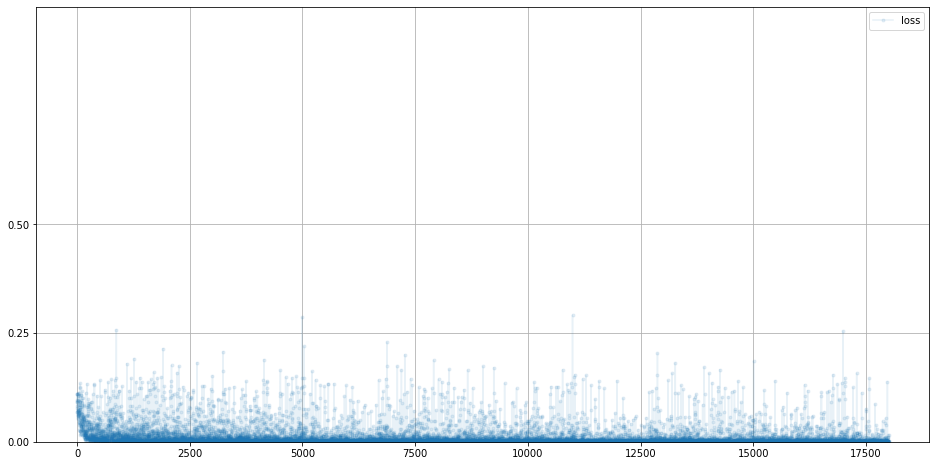

In [24]:
# plot classifer error

C.plot_progress()

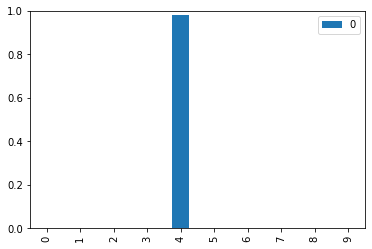

In [25]:
# Visualize the answer given by the neural network

record = 19
image_data = mnist_test_dataset[record][1]

# query form trained network
output = C.forward(image_data)

# plot output tensor
pandas.DataFrame(output.detach().numpy()).plot(kind='bar', legend='False', ylim=(0,1))

<br>

## 정규화

<br>

✅ **정규화$^{normalization}$**<br>
  : 파라미터의 범위를 감소하거나, 평균을 0으로 맞춰주는 작업<br>
  : 신경망 훈련을 안정화시키는 기능<br>
  &nbsp;&nbsp;&nbsp;&nbsp; ↪ 신경망의 초기 가중치를 정규화하는 것은 일반적인 일!

```
# How to use LayerNorm in Neural Network Layer

self.model = nn.Sequential(
  nn.Linear(784,200),
  nn.Sigmoid(),

  LayerNorm(200),

  nn.Linear(200,10),
  nn.Sigmoid()
)

```

↪ 신경망 레이어들을 통과하기 전에 정규화 작업을 거쳐, 네트워크 신호들을 모두 표준화.

<br>


➡ 상단 분류기 클래스에서 신경망 레이어에 LayerNorm을 추가해주자

In [28]:
%%time

# 신경망 생성
C = Classifier()


# MNIST 데이터에 대해 훈련 진행
epochs = 3

for i in range(epochs):
  print('training epoch', i+1, 'of', epochs)
  for label, image_data_tensor, target_tensor in mnist_dataset:
    C.train(image_data_tensor, target_tensor)

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 3min 42s, sys: 2.11 s, total: 3min 44s
Wall time: 3min 44s


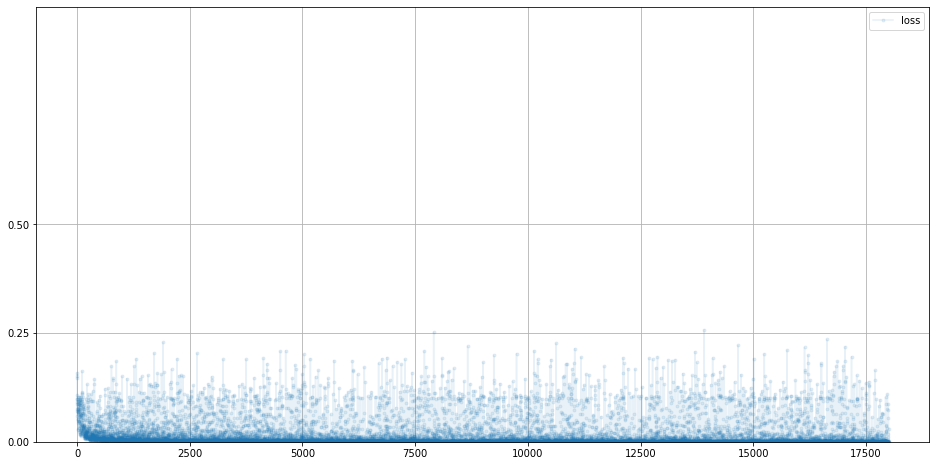

In [29]:
# plot classifer error

C.plot_progress()

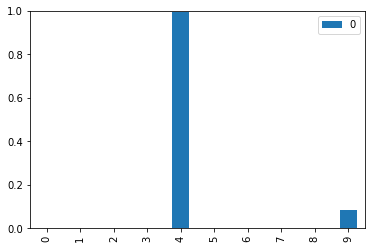

In [30]:
# Visualize the answer given by the neural network

record = 19
image_data = mnist_test_dataset[record][1]

# query form trained network
output = C.forward(image_data)

# plot output tensor
pandas.DataFrame(output.detach().numpy()).plot(kind='bar', legend='False', ylim=(0,1))

<br>

## 복합적 성능 향상 기법

➡ 상단 분류기 클래스에서 신경망 레이어에 아래의 것들을 모두 적용하여 주자!
* BCELoss
* LeakyReLU
* Adam
* LayerNorm

&nbsp;&nbsp;&nbsp;&nbsp; ↪ 이때, BCE 손실같은 경우 0과 1사이 외의 값은 받을 수 없는데, Leaky ReLU에서는 그외의 값들이 나올 수 있으므로 문제가 생길 수 있으므로 주의.

In [36]:
%%time

# 신경망 생성
C = Classifier()


# MNIST 데이터에 대해 훈련 진행
epochs = 3

for i in range(epochs):
  print('training epoch', i+1, 'of', epochs)
  for label, image_data_tensor, target_tensor in mnist_dataset:
    C.train(image_data_tensor, target_tensor)

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 10min 54s, sys: 5.6 s, total: 10min 59s
Wall time: 10min 58s


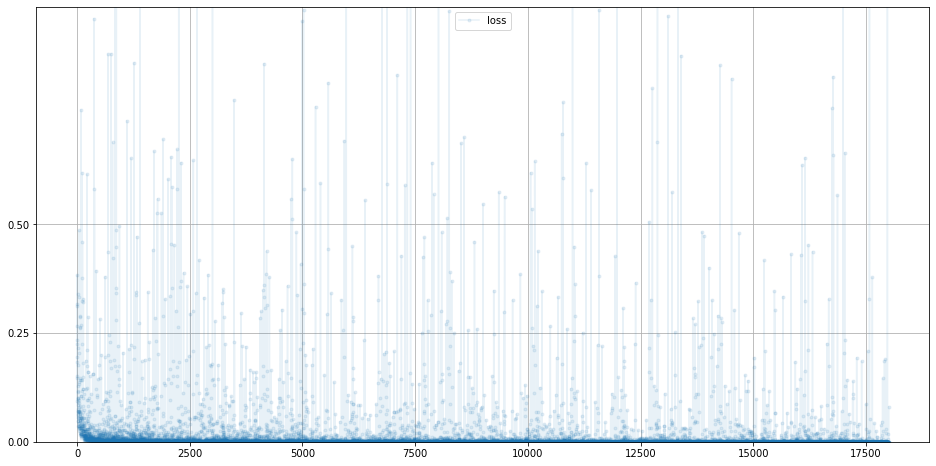

In [37]:
# plot classifer error

C.plot_progress()

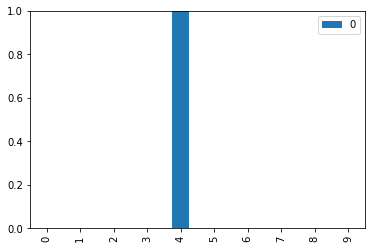

In [38]:
# Visualize the answer given by the neural network

record = 19
image_data = mnist_test_dataset[record][1]

# query form trained network
output = C.forward(image_data)

# plot output tensor
pandas.DataFrame(output.detach().numpy()).plot(kind='bar', legend='False', ylim=(0,1))

---

## **Summary**
>* 새로운 데이터를 다루거나 새로운 워크플로우를 만들 때,<br>
데이터를 미리 살펴보고 제대로 로딩되었는지, 혹은 변환되었는지 확인하는 것이 좋은 습관!
* 파이토치는 머신러닝 훈련 시 많은 작업을 대신 수행해줌!<br>
예를 들어, 신경망은 파이토치의 **nn.Module 클래스**로부터 시작하면 됨!
<br>
<br>
* 훈련이 어떻게 되어가고 있는지 **손실값**을 시각화하는 것이 좋음!
<br>
<br>
<br>
* **평균제곱오차 손실** => **회귀**문제에 적합<br>
  **이진 교차 엔트로피** => **분류**문제에 적합
  <br>
<br>
<br>
* 전통적인 **시그모이드 활성화 함수**<br>
  => 큰 입력값에 대해 **기울기 소실**문제가 일어날 수 있음.<br>
  => 이는 신경망 훈련 시, 약한 역전파 신호로 귀착될 수 있음.<br>
* **ReLU 활성화 함수**<br>
  => 양의 입력에 대해 적절한 기울기를 지니게 함.<br>
  => 음의 입력값에 대해서도 약간의 기울기를 지니게 함으로써 더 나은 결과를 유도함.<br>
<br>
<br>
* **Adam 옵티마이저**<br>
  => 관성을 이용해 국소최적해 문제를 해결함.<br>
  => 각 학습 파라미터마다 다른 학습률을 적용.<br>
  (많은 작업에 대해 대체적으로 SGD 옵티마이저보다 나은 성능을 보여줌)<br>
<br>
<br>
* **정규화**<br>
  => 신경망 훈련을 안정화시킴.<br>
  => 신경망의 초기 가중치를 정규화하는 것이 일반적.<br>
  => **LayerNorm**을 통해 신경망의 신호를 정규화 -> 더 나은 성능으로 이어짐
<br>
<br>


---